In [4]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import os

db_config = {
    'host': '34.93.93.62',
    'port': '5432',
    'database': 'matomo_analytics',
    'user': 'postgres',
    'password': 'Y5mnshpDFF44'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

In [6]:
query_logs = "SELECT * FROM matomo_log_visit"
query_link = "SELECT * FROM matomo_log_link_visit_action"
query_action = "SELECT * FROM matomo_log_action"

logs = pd.read_sql(query_logs, engine)
link = pd.read_sql(query_link, engine)
action = pd.read_sql(query_action, engine)

In [7]:
url_prefix_map = {
    0: 'http://',
    1: 'http://www.',
    2: 'https://',
    3: 'https://www.'
}

action['url_prefix_text'] = action['url_prefix'].map(url_prefix_map)
action['full_url'] = action['url_prefix_text'] + action['name']
action = action.dropna(subset=['full_url'])

In [23]:
merged_data = link.merge(action[['idaction', 'full_url']], left_on='idaction_url', right_on='idaction', how='left')
final_dataset = merged_data.merge(logs, on='idvisit', how='left')

# Convert memoryview columns to strings to avoid sorting/comparison issues
if 'idvisitor_y' in final_dataset.columns:
    final_dataset['idvisitor_y'] = final_dataset['idvisitor_y'].astype(str)
if 'idvisitor_x' in final_dataset.columns:
    final_dataset['idvisitor_x'] = final_dataset['idvisitor_x'].astype(str)
if 'idvisit' in final_dataset.columns:
    final_dataset['idvisit'] = final_dataset['idvisit'].astype(str)

print(f"Dataset shape: {final_dataset.shape}")
print(f"Columns: {list(final_dataset.columns)}")

Dataset shape: (275359, 102)
Columns: ['idlink_va', 'idsite_x', 'idvisitor_x', 'idvisit', 'idaction_url_ref', 'idaction_name_ref', 'custom_float', 'pageview_position', 'server_time', 'idpageview', 'idaction_name', 'idaction_url', 'search_cat', 'search_count', 'time_spent_ref_action', 'idaction_product_cat', 'idaction_product_cat2', 'idaction_product_cat3', 'idaction_product_cat4', 'idaction_product_cat5', 'idaction_product_name', 'product_price', 'idaction_product_sku', 'idaction_event_action', 'idaction_event_category', 'idaction_content_interaction', 'idaction_content_name', 'idaction_content_piece', 'idaction_content_target', 'time_dom_completion', 'time_dom_processing', 'time_network', 'time_on_load', 'time_server', 'time_transfer', 'time_spent', 'custom_dimension_1_x', 'custom_dimension_2_x', 'custom_dimension_3_x', 'custom_dimension_4_x', 'custom_dimension_5_x', 'idaction', 'full_url', 'idsite_y', 'idvisitor_y', 'visit_last_action_time', 'config_id', 'location_ip', 'profilable', 

In [14]:
def create_detailed_url_tree_with_user_counts(df):
    url_tree = {}
    
    for _, row in df.dropna(subset=['full_url']).iterrows():
        url = row['full_url']
        visitor_id = row['idvisitor_y']  # Use idvisitor_y from logs table
        
        domain_match = re.search(r'https?://(?:www\.)?([^/]+)', url)
        if not domain_match:
            continue
            
        domain = domain_match.group(1)
        path = url[domain_match.end():]
        
        if domain not in url_tree:
            url_tree[domain] = {'user_count': set(), 'features': {}}
        url_tree[domain]['user_count'].add(visitor_id)
        
        path_parts = [p for p in path.split('/') if p]
        if path_parts:
            feature = path_parts[0]
            if feature not in url_tree[domain]['features']:
                url_tree[domain]['features'][feature] = {'user_count': set(), 'sub_features': {}}
            url_tree[domain]['features'][feature]['user_count'].add(visitor_id)
            
            if len(path_parts) > 1:
                sub_feature = path_parts[1]
                if sub_feature not in url_tree[domain]['features'][feature]['sub_features']:
                    url_tree[domain]['features'][feature]['sub_features'][sub_feature] = {'user_count': set()}
                url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'].add(visitor_id)
    
    for domain in url_tree:
        url_tree[domain]['user_count'] = len(url_tree[domain]['user_count'])
        for feature in url_tree[domain]['features']:
            url_tree[domain]['features'][feature]['user_count'] = len(url_tree[domain]['features'][feature]['user_count'])
            for sub_feature in url_tree[domain]['features'][feature]['sub_features']:
                url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'] = len(url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'])
    
    return url_tree

In [15]:
def analyze_layers_with_user_counts(url_tree):
    layers = {
        'domains': [],
        'features': [],
        'sub_features': []
    }
    
    for domain, domain_data in url_tree.items():
        layers['domains'].append({
            'name': domain,
            'user_count': domain_data['user_count']
        })
        
        for feature, feature_data in domain_data['features'].items():
            layers['features'].append({
                'name': f"{domain}/{feature}",
                'user_count': feature_data['user_count'],
                'domain': domain
            })
            
            for sub_feature, sub_data in feature_data['sub_features'].items():
                layers['sub_features'].append({
                    'name': f"{domain}/{feature}/{sub_feature}",
                    'user_count': sub_data['user_count'],
                    'domain': domain,
                    'feature': feature
                })
    
    for layer_name, layer_data in layers.items():
        layer_data.sort(key=lambda x: x['user_count'], reverse=True)
    
    return layers

In [16]:
url_tree = create_detailed_url_tree_with_user_counts(final_dataset)
layers = analyze_layers_with_user_counts(url_tree)

print("Top 10 Domains by User Count:")
for i, domain in enumerate(layers['domains'][:10]):
    print(f"{i+1}. {domain['name']}: {domain['user_count']} users")
    
print("\nTop 10 Features by User Count:")
for i, feature in enumerate(layers['features'][:10]):
    print(f"{i+1}. {feature['name']}: {feature['user_count']} users")

Top 10 Domains by User Count:
1. devpy.vipani.ai: 811 users
2. localhost: 196 users
3. ecomst.vipani.ai: 174 users
4. stuam.vipani.ai: 116 users
5. 192.168.9.181: 100 users
6. unify.vipani.ai: 91 users
7. demopy.vipani.ai: 23 users
8. asaco.vipani.ai: 17 users
9. 192.168.9.146: 16 users
10. 192.168.9.133: 14 users

Top 10 Features by User Count:
1. devpy.vipani.ai/auth: 702 users
2. devpy.vipani.ai/rfq: 439 users
3. devpy.vipani.ai/e-commerce: 270 users
4. devpy.vipani.ai/order-management: 261 users
5. devpy.vipani.ai/prf: 180 users
6. devpy.vipani.ai/auction: 169 users
7. devpy.vipani.ai/deal-room: 156 users
8. devpy.vipani.ai/onBoard: 146 users
9. devpy.vipani.ai/buyer-auction: 143 users
10. ecomst.vipani.ai/auth: 134 users


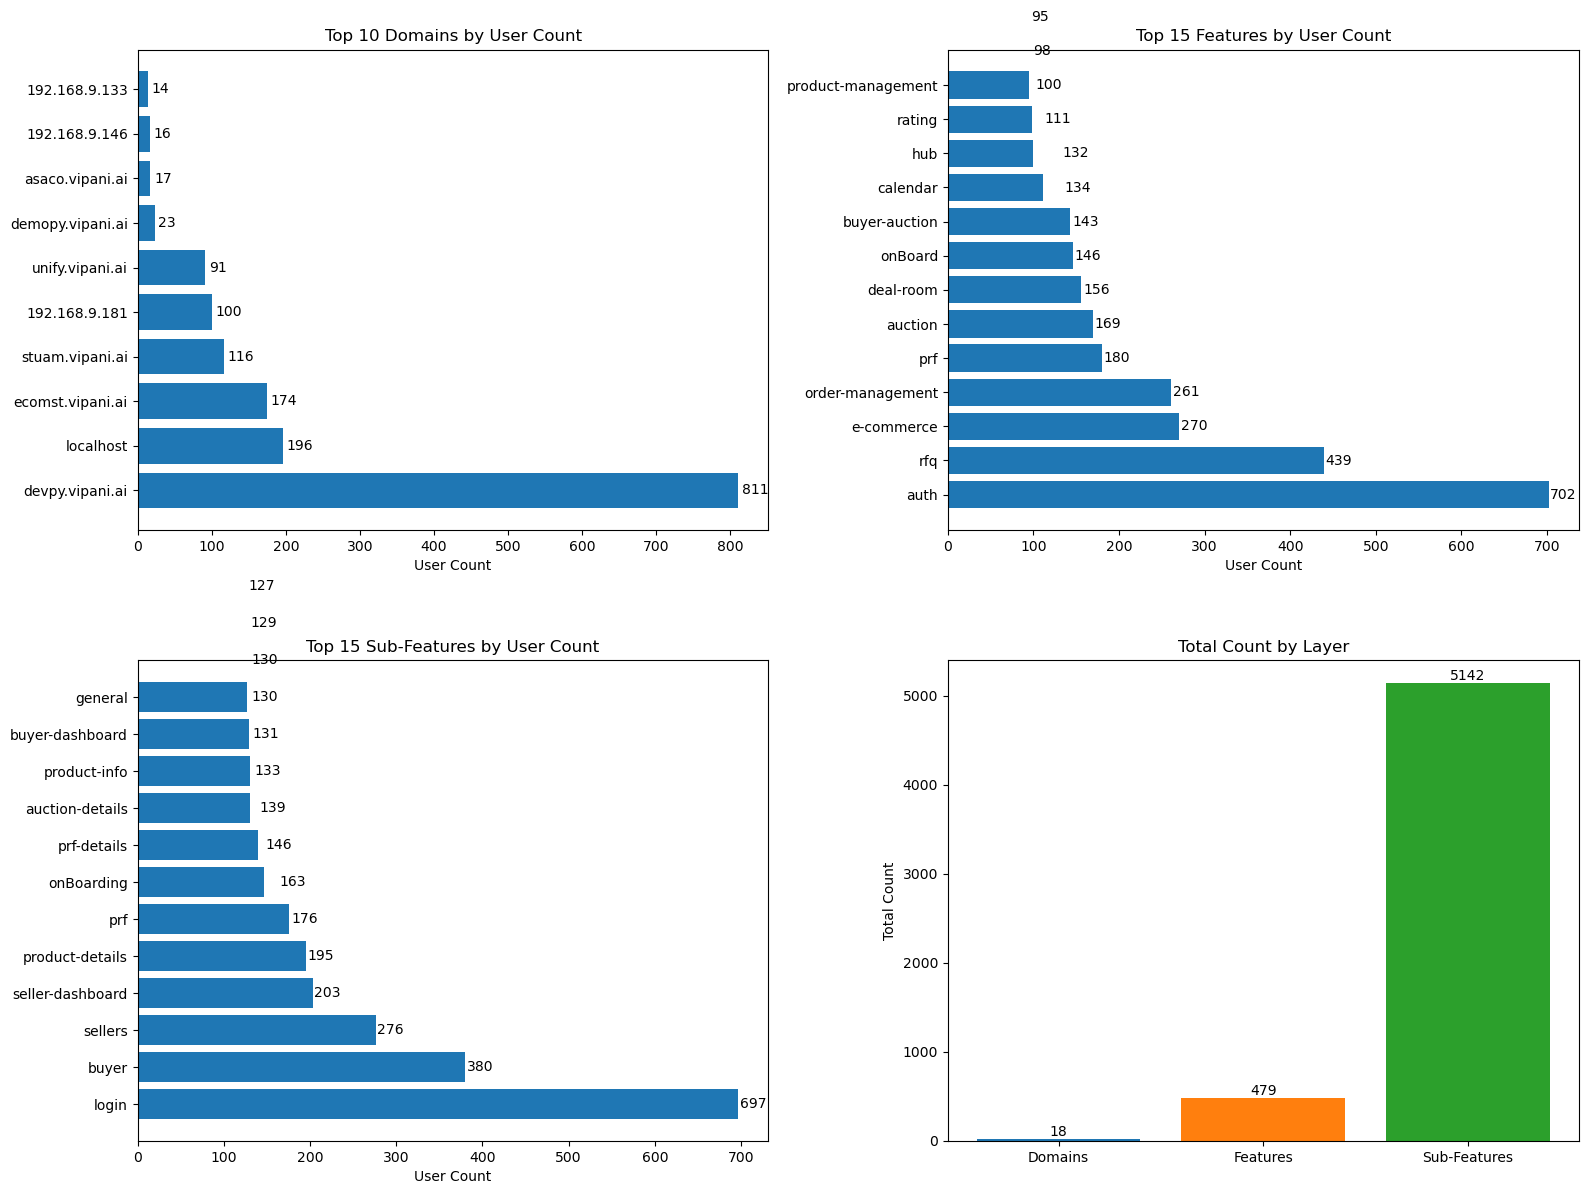

Layer Summary:
Total Domains: 18
Total Features: 479
Total Sub-Features: 5142

Average users per domain: 87.7
Average users per feature: 11.9
Average users per sub-feature: 3.1


In [18]:
import numpy as np

# Create bar plots showing top features at each layer
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 Domains
top_domains = layers['domains'][:10]
domain_names = [d['name'] for d in top_domains]
domain_counts = [d['user_count'] for d in top_domains]

axes[0, 0].barh(domain_names, domain_counts)
axes[0, 0].set_title('Top 10 Domains by User Count')
axes[0, 0].set_xlabel('User Count')
for i, v in enumerate(domain_counts):
    axes[0, 0].text(v + 5, i, str(v), va='center')

# 2. Top 15 Features
top_features = layers['features'][:15]
feature_names = [f['name'].split('/')[-1] for f in top_features]  # Show only feature name
feature_counts = [f['user_count'] for f in top_features]

axes[0, 1].barh(feature_names, feature_counts)
axes[0, 1].set_title('Top 15 Features by User Count')
axes[0, 1].set_xlabel('User Count')
for i, v in enumerate(feature_counts):
    axes[0, 1].text(v + 2, i, str(v), va='center')

# 3. Top 15 Sub-Features
top_sub_features = layers['sub_features'][:15]
sub_feature_names = [s['name'].split('/')[-1] for s in top_sub_features]  # Show only sub-feature name
sub_feature_counts = [s['user_count'] for s in top_sub_features]

axes[1, 0].barh(sub_feature_names, sub_feature_counts)
axes[1, 0].set_title('Top 15 Sub-Features by User Count')
axes[1, 0].set_xlabel('User Count')
for i, v in enumerate(sub_feature_counts):
    axes[1, 0].text(v + 2, i, str(v), va='center')

# 4. Layer comparison
layer_summary = {
    'Domains': len(layers['domains']),
    'Features': len(layers['features']),
    'Sub-Features': len(layers['sub_features'])
}

layer_names = list(layer_summary.keys())
layer_totals = list(layer_summary.values())

bars = axes[1, 1].bar(layer_names, layer_totals, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_title('Total Count by Layer')
axes[1, 1].set_ylabel('Total Count')
for bar, count in zip(bars, layer_totals):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Layer Summary:")
print("=" * 50)
print(f"Total Domains: {len(layers['domains'])}")
print(f"Total Features: {len(layers['features'])}")
print(f"Total Sub-Features: {len(layers['sub_features'])}")
print(f"\nAverage users per domain: {np.mean([d['user_count'] for d in layers['domains']]):.1f}")
print(f"Average users per feature: {np.mean([f['user_count'] for f in layers['features']]):.1f}")
print(f"Average users per sub-feature: {np.mean([s['user_count'] for s in layers['sub_features']]):.1f}")

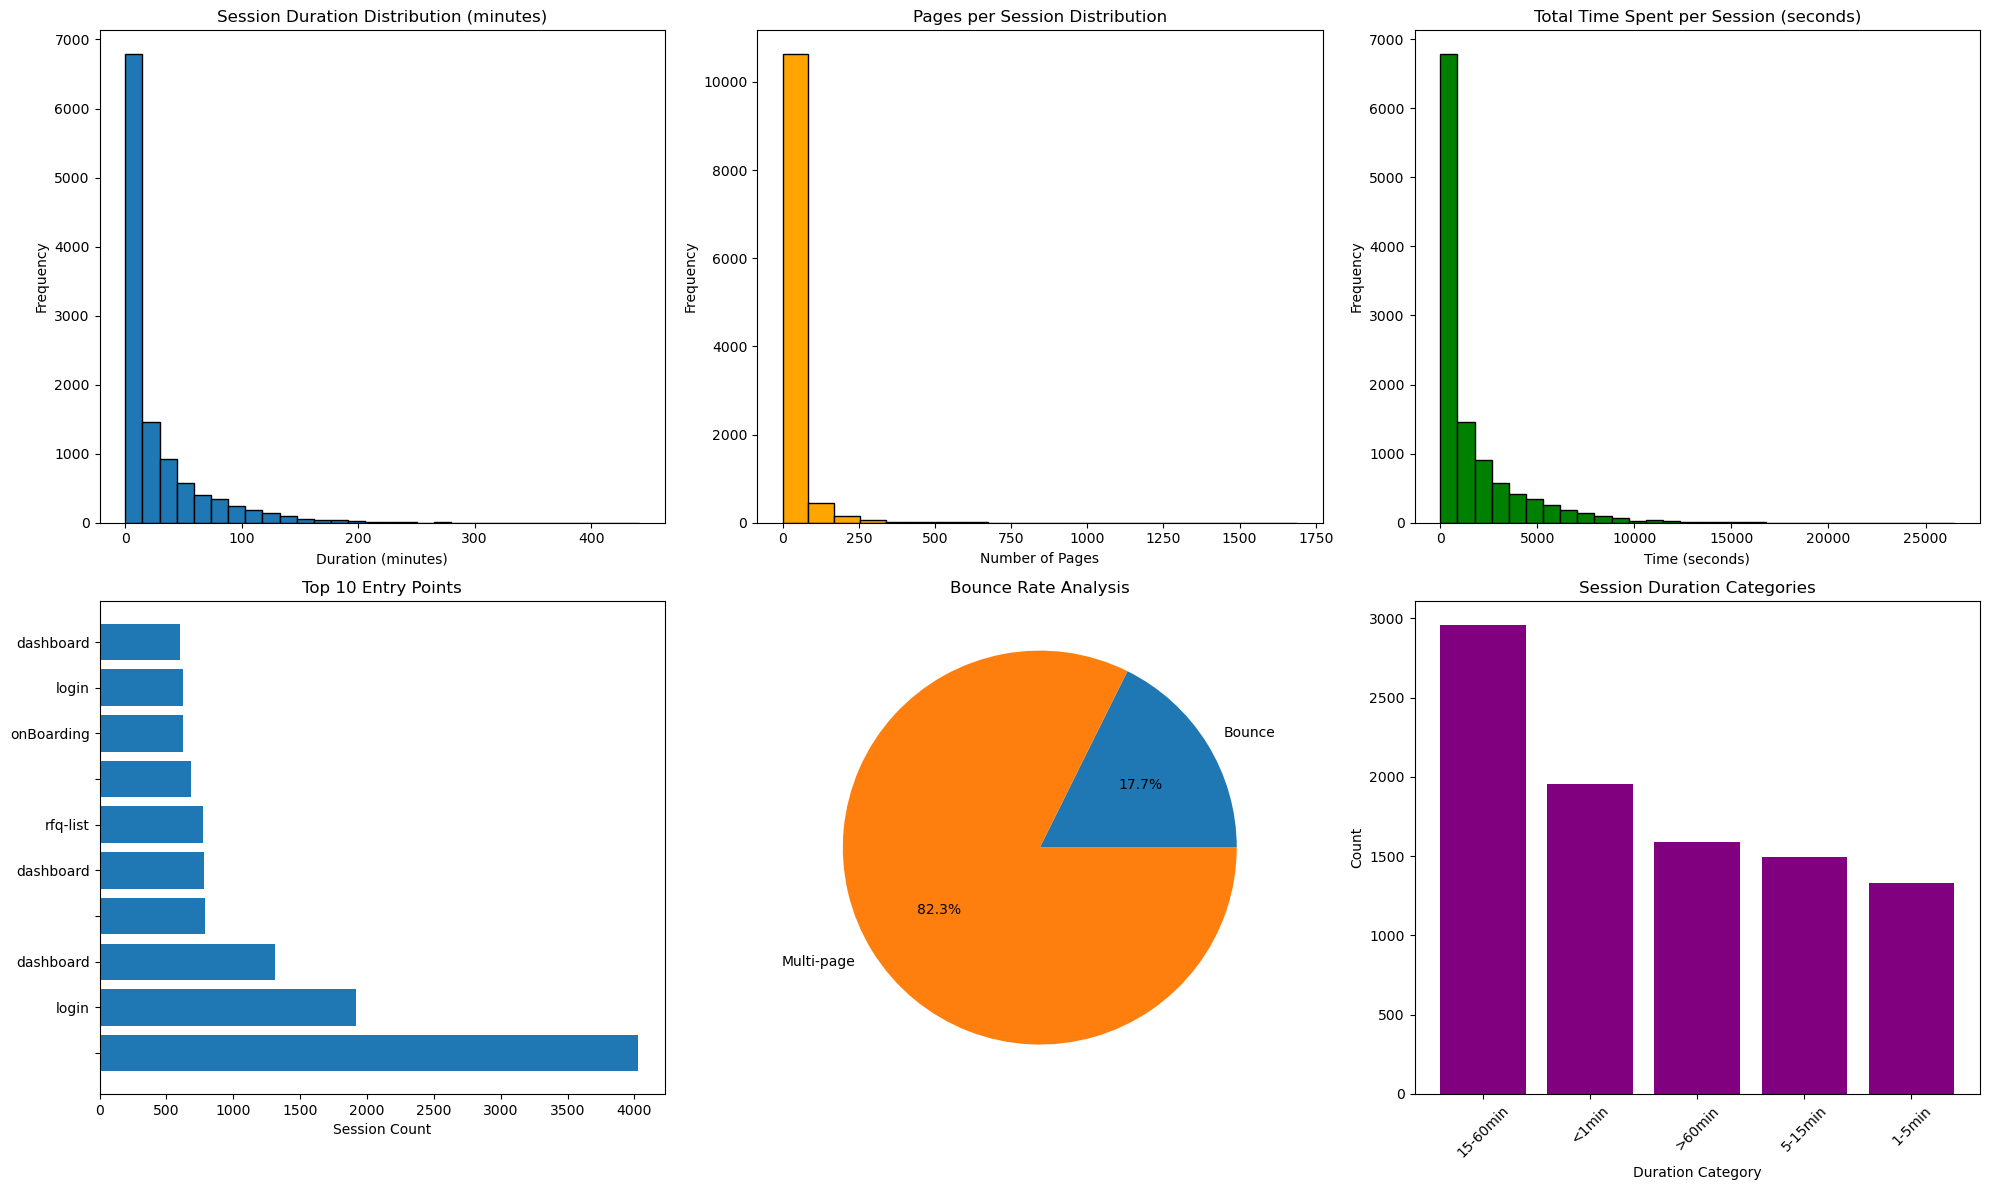

User Journey Insights:
Total Sessions: 11366
Average Session Duration: 24.68 minutes
Average Pages per Session: 24.22
Bounce Rate: 17.6%
Average Time Spent: 1492.17 seconds


In [24]:
# User Journey Analysis Dashboard
def analyze_user_journeys(df):
    # Clean and convert data types to avoid memoryview issues
    df_clean = df.copy()
    
    # Convert memoryview columns to strings if needed
    if 'idvisitor_y' in df_clean.columns:
        df_clean['idvisitor_y'] = df_clean['idvisitor_y'].astype(str)
    if 'idvisit' in df_clean.columns:
        df_clean['idvisit'] = df_clean['idvisit'].astype(str)
    
    # Create user session paths
    user_sessions = df_clean.groupby(['idvisit', 'idvisitor_y']).agg({
        'full_url': lambda x: ' → '.join(x.dropna().astype(str)),
        'pageview_position': 'count',
        'server_time': ['min', 'max'],
        'time_spent_ref_action': 'sum'
    }).reset_index()
    
    user_sessions.columns = ['idvisit', 'idvisitor', 'journey_path', 'page_count', 'session_start', 'session_end', 'total_time_spent']
    user_sessions['session_duration'] = (pd.to_datetime(user_sessions['session_end']) - pd.to_datetime(user_sessions['session_start'])).dt.total_seconds() / 60
    
    return user_sessions

def create_journey_dashboard(df):
    journeys = analyze_user_journeys(df)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Session Duration Distribution
    axes[0, 0].hist(journeys['session_duration'].dropna(), bins=30, edgecolor='black')
    axes[0, 0].set_title('Session Duration Distribution (minutes)')
    axes[0, 0].set_xlabel('Duration (minutes)')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Pages per Session
    axes[0, 1].hist(journeys['page_count'], bins=20, edgecolor='black', color='orange')
    axes[0, 1].set_title('Pages per Session Distribution')
    axes[0, 1].set_xlabel('Number of Pages')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Time Spent Distribution
    axes[0, 2].hist(journeys['total_time_spent'].dropna(), bins=30, edgecolor='black', color='green')
    axes[0, 2].set_title('Total Time Spent per Session (seconds)')
    axes[0, 2].set_xlabel('Time (seconds)')
    axes[0, 2].set_ylabel('Frequency')
    
    # 4. Entry Points Analysis
    entry_points = df.groupby('full_url')['idvisit'].nunique().sort_values(ascending=False).head(10)
    axes[1, 0].barh(range(len(entry_points)), entry_points.values)
    axes[1, 0].set_yticks(range(len(entry_points)))
    axes[1, 0].set_yticklabels([url.split('/')[-1][:20] + '...' if len(url.split('/')[-1]) > 20 else url.split('/')[-1] for url in entry_points.index])
    axes[1, 0].set_title('Top 10 Entry Points')
    axes[1, 0].set_xlabel('Session Count')
    
    # 5. Bounce Rate Analysis
    bounce_sessions = journeys[journeys['page_count'] == 1].shape[0]
    multi_page_sessions = journeys[journeys['page_count'] > 1].shape[0]
    axes[1, 1].pie([bounce_sessions, multi_page_sessions], labels=['Bounce', 'Multi-page'], autopct='%1.1f%%')
    axes[1, 1].set_title('Bounce Rate Analysis')
    
    # 6. Session Length Categories
    journeys['duration_category'] = pd.cut(journeys['session_duration'].fillna(0), 
                                         bins=[0, 1, 5, 15, 60, float('inf')], 
                                         labels=['<1min', '1-5min', '5-15min', '15-60min', '>60min'])
    duration_counts = journeys['duration_category'].value_counts()
    axes[1, 2].bar(duration_counts.index, duration_counts.values, color='purple')
    axes[1, 2].set_title('Session Duration Categories')
    axes[1, 2].set_xlabel('Duration Category')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("User Journey Insights:")
    print("=" * 50)
    print(f"Total Sessions: {len(journeys)}")
    print(f"Average Session Duration: {journeys['session_duration'].mean():.2f} minutes")
    print(f"Average Pages per Session: {journeys['page_count'].mean():.2f}")
    print(f"Bounce Rate: {(bounce_sessions / len(journeys) * 100):.1f}%")
    print(f"Average Time Spent: {journeys['total_time_spent'].mean():.2f} seconds")
    
    return journeys

journeys_data = create_journey_dashboard(final_dataset)

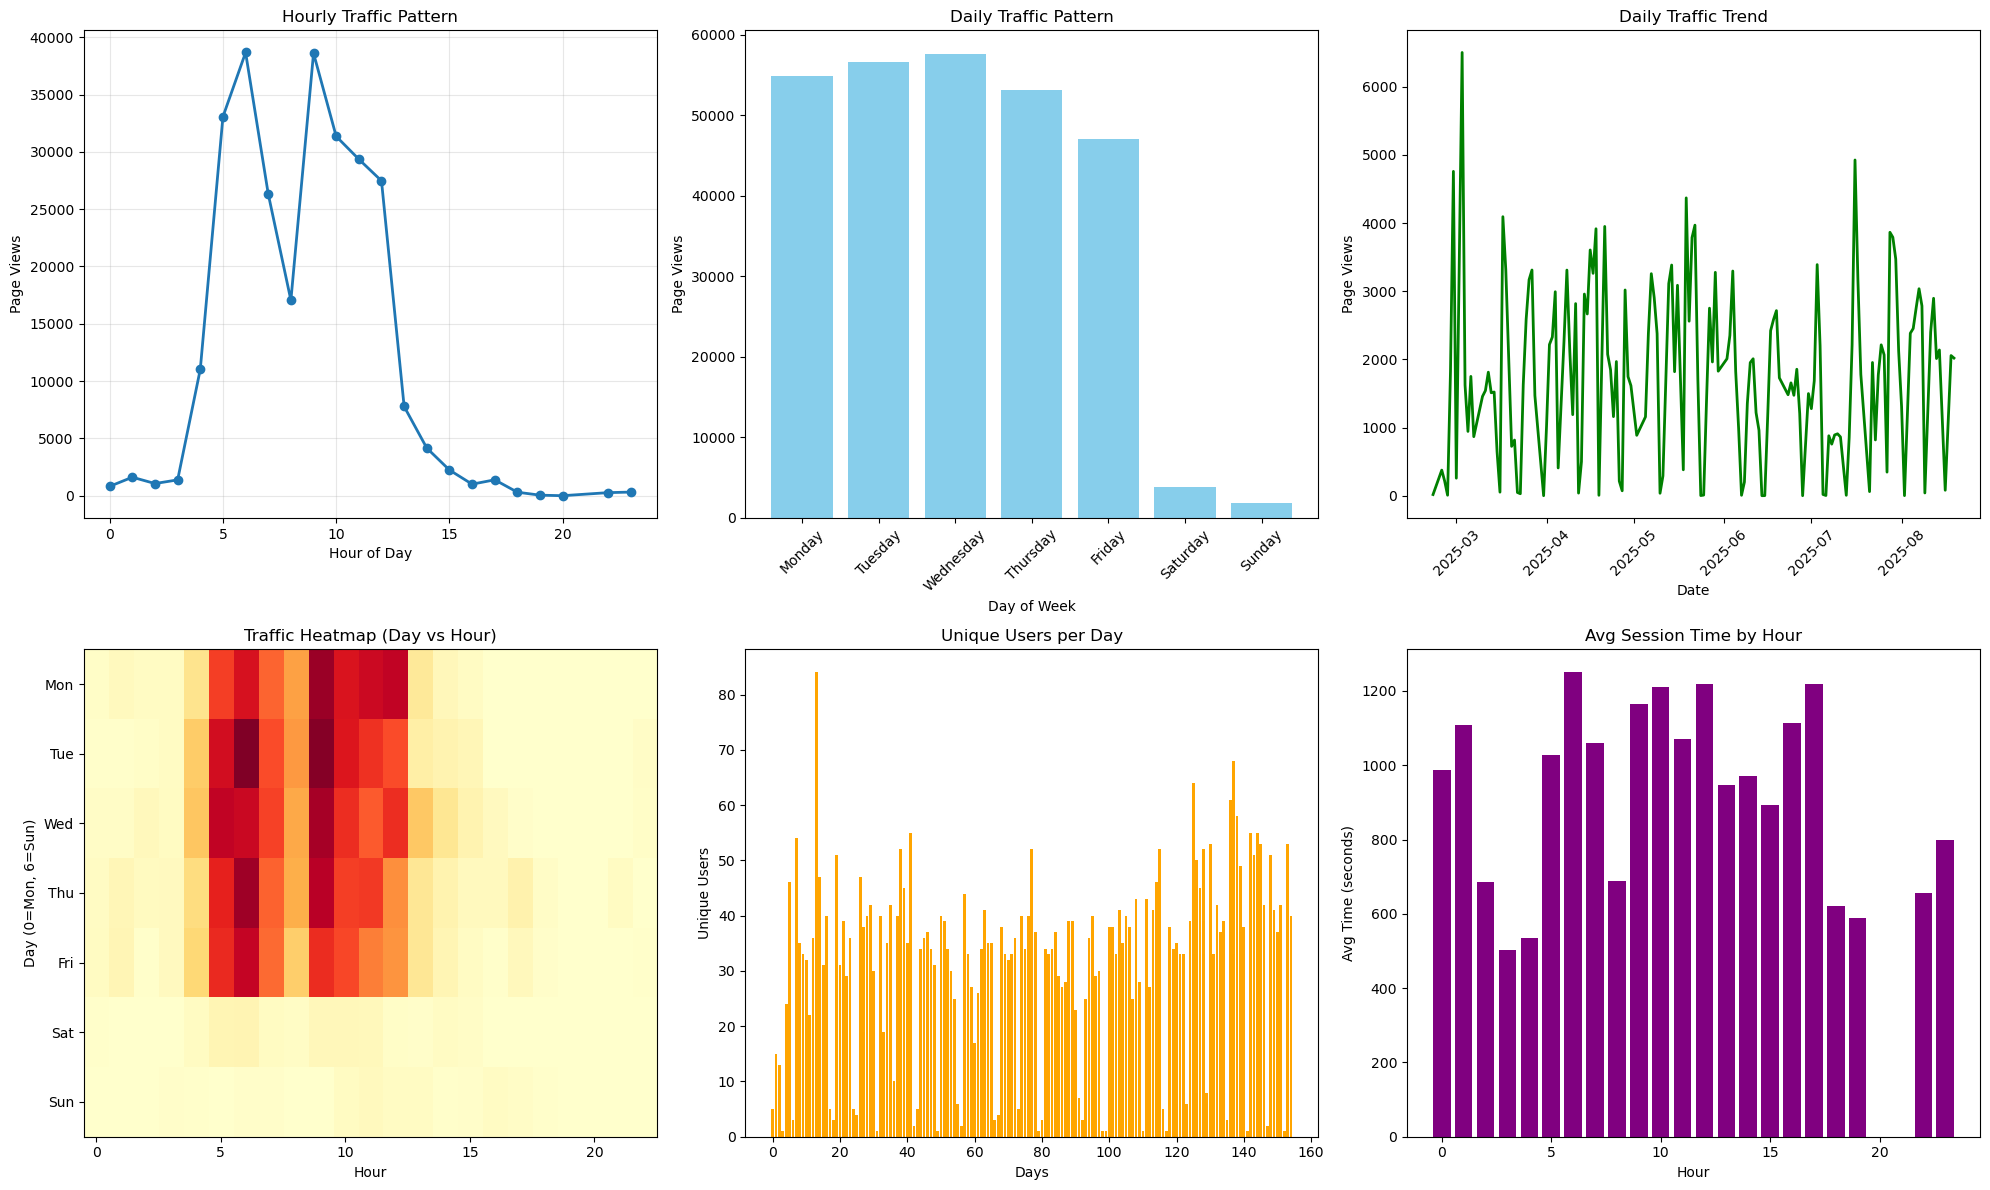

Time-Based Analytics Insights:
Peak Traffic Hour: 6:00 (38672 views)
Peak Traffic Day: Wednesday (57693 views)
Total Unique Users: 1302
Date Range: 2025-02-21 to 2025-08-19


In [20]:
# Time-Based Analytics Dashboard
def create_time_analytics_dashboard(df):
    # Convert server_time to datetime
    df['datetime'] = pd.to_datetime(df['server_time'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day_name()
    df['date'] = df['datetime'].dt.date
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Hourly Traffic Pattern
    hourly_traffic = df.groupby('hour').size()
    axes[0, 0].plot(hourly_traffic.index, hourly_traffic.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Hourly Traffic Pattern')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Page Views')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Daily Traffic Pattern
    daily_traffic = df.groupby('day').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes[0, 1].bar(daily_traffic.index, daily_traffic.values, color='skyblue')
    axes[0, 1].set_title('Daily Traffic Pattern')
    axes[0, 1].set_xlabel('Day of Week')
    axes[0, 1].set_ylabel('Page Views')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Daily Trend
    daily_trend = df.groupby('date').size()
    axes[0, 2].plot(daily_trend.index, daily_trend.values, linewidth=2, color='green')
    axes[0, 2].set_title('Daily Traffic Trend')
    axes[0, 2].set_xlabel('Date')
    axes[0, 2].set_ylabel('Page Views')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Peak Hours Heatmap
    df['day_num'] = df['datetime'].dt.dayofweek
    heatmap_data = df.groupby(['day_num', 'hour']).size().unstack(fill_value=0)
    im = axes[1, 0].imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
    axes[1, 0].set_title('Traffic Heatmap (Day vs Hour)')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Day (0=Mon, 6=Sun)')
    axes[1, 0].set_yticks(range(7))
    axes[1, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # 5. Unique Users per Day
    daily_users = df.groupby('date')['idvisitor_y'].nunique()
    axes[1, 1].bar(range(len(daily_users)), daily_users.values, color='orange')
    axes[1, 1].set_title('Unique Users per Day')
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('Unique Users')
    
    # 6. Average Session Length by Hour
    hourly_sessions = df.groupby(['hour', 'idvisit'])['time_spent_ref_action'].sum().groupby('hour').mean()
    axes[1, 2].bar(hourly_sessions.index, hourly_sessions.values, color='purple')
    axes[1, 2].set_title('Avg Session Time by Hour')
    axes[1, 2].set_xlabel('Hour')
    axes[1, 2].set_ylabel('Avg Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("Time-Based Analytics Insights:")
    print("=" * 50)
    peak_hour = hourly_traffic.idxmax()
    peak_day = daily_traffic.idxmax()
    print(f"Peak Traffic Hour: {peak_hour}:00 ({hourly_traffic[peak_hour]} views)")
    print(f"Peak Traffic Day: {peak_day} ({daily_traffic[peak_day]} views)")
    print(f"Total Unique Users: {df['idvisitor_y'].nunique()}")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

create_time_analytics_dashboard(final_dataset)

/tmp/ipykernel_1781111/431326832.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  page_transitions = df.groupby(['idvisit']).apply(


TypeError: '<' not supported between instances of 'memoryview' and 'memoryview'

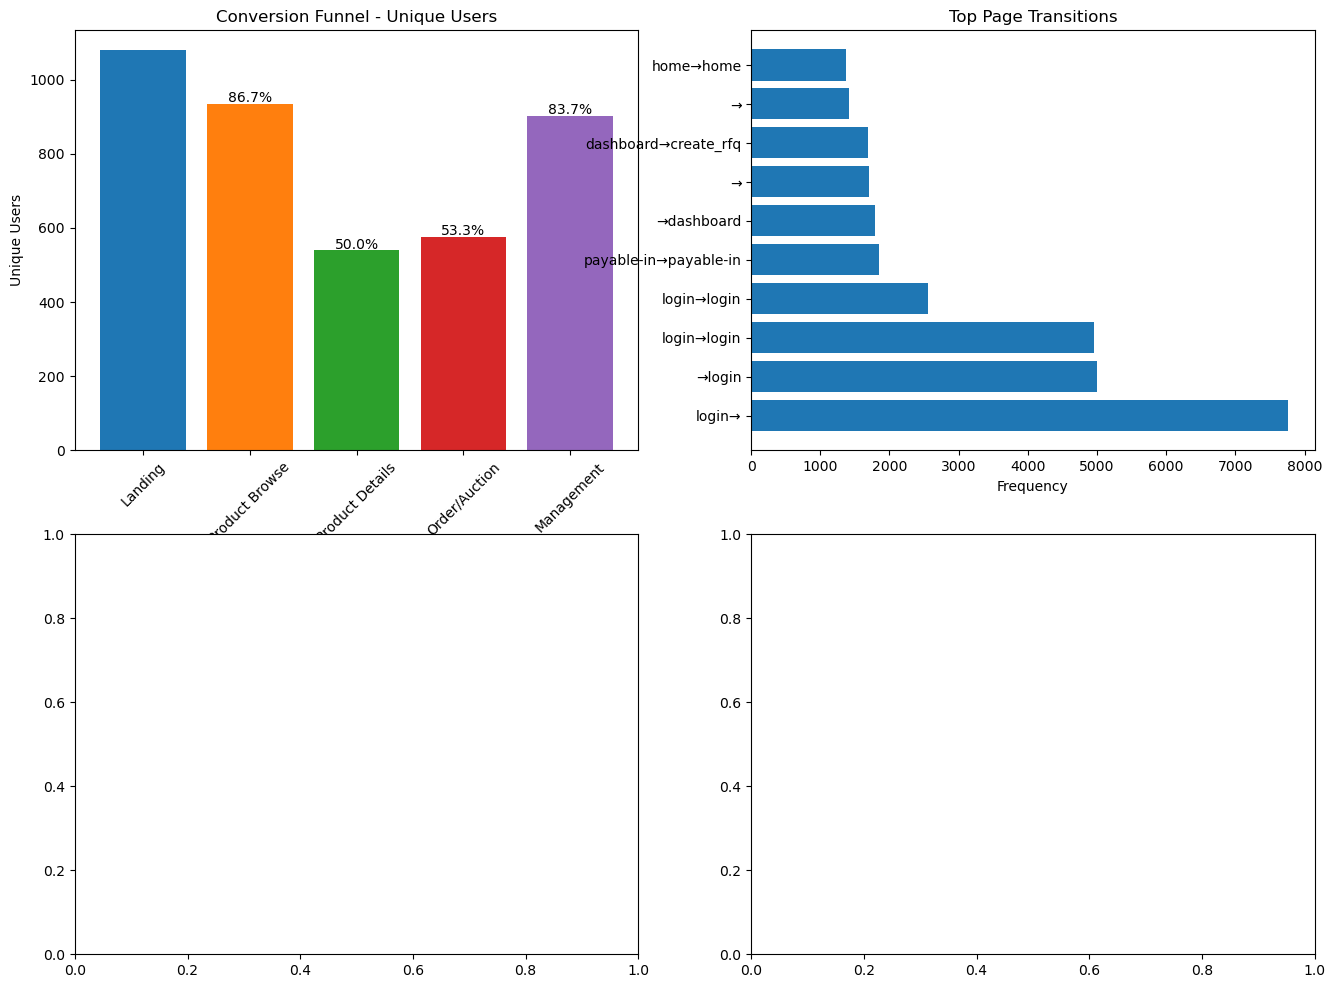

In [21]:
# Conversion Funnel and User Flow Analysis
def create_funnel_analysis(df):
    # Define key pages in the conversion funnel
    funnel_pages = {
        'Landing': df['full_url'].str.contains('auth|login', case=False, na=False),
        'Product Browse': df['full_url'].str.contains('product|e-commerce|rfq', case=False, na=False),
        'Product Details': df['full_url'].str.contains('product-details|prf', case=False, na=False),
        'Order/Auction': df['full_url'].str.contains('order|auction|deal-room', case=False, na=False),
        'Management': df['full_url'].str.contains('management|dashboard', case=False, na=False)
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Funnel Conversion
    funnel_counts = {}
    for stage, condition in funnel_pages.items():
        funnel_counts[stage] = df[condition]['idvisitor_y'].nunique()
    
    stages = list(funnel_counts.keys())
    counts = list(funnel_counts.values())
    
    axes[0, 0].bar(stages, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    axes[0, 0].set_title('Conversion Funnel - Unique Users')
    axes[0, 0].set_ylabel('Unique Users')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add conversion rates
    for i, (stage, count) in enumerate(zip(stages, counts)):
        if i > 0:
            conversion_rate = (count / counts[0]) * 100
            axes[0, 0].text(i, count + 5, f'{conversion_rate:.1f}%', ha='center')
    
    # 2. Page Flow Analysis
    page_transitions = df.groupby(['idvisit']).apply(
        lambda x: list(zip(x['full_url'].iloc[:-1], x['full_url'].iloc[1:]))
    ).explode().dropna()
    
    if len(page_transitions) > 0:
        transition_counts = page_transitions.value_counts().head(10)
        transition_labels = [f"{t[0].split('/')[-1][:10]}→{t[1].split('/')[-1][:10]}" for t in transition_counts.index]
        
        axes[0, 1].barh(range(len(transition_counts)), transition_counts.values)
        axes[0, 1].set_yticks(range(len(transition_counts)))
        axes[0, 1].set_yticklabels(transition_labels)
        axes[0, 1].set_title('Top Page Transitions')
        axes[0, 1].set_xlabel('Frequency')
    
    # 3. User Segment Analysis
    user_behavior = df.groupby('idvisitor_y').agg({
        'full_url': 'count',
        'idvisit': 'nunique',
        'time_spent_ref_action': 'sum'
    }).rename(columns={'full_url': 'page_views', 'idvisit': 'sessions', 'time_spent_ref_action': 'total_time'})
    
    # Categorize users
    user_behavior['user_type'] = 'Low Engagement'
    user_behavior.loc[(user_behavior['page_views'] > 5) & (user_behavior['sessions'] > 1), 'user_type'] = 'Medium Engagement'
    user_behavior.loc[(user_behavior['page_views'] > 20) | (user_behavior['total_time'] > 300), 'user_type'] = 'High Engagement'
    
    user_segments = user_behavior['user_type'].value_counts()
    axes[1, 0].pie(user_segments.values, labels=user_segments.index, autopct='%1.1f%%')
    axes[1, 0].set_title('User Engagement Segments')
    
    # 4. Feature Usage Matrix
    features_used = df.groupby('idvisitor_y')['full_url'].apply(
        lambda x: [url.split('/')[3] if len(url.split('/')) > 3 else 'root' for url in x if pd.notna(url)]
    ).apply(lambda x: len(set(x)))
    
    axes[1, 1].hist(features_used, bins=20, edgecolor='black', color='lightcoral')
    axes[1, 1].set_title('Features Used per User')
    axes[1, 1].set_xlabel('Number of Different Features')
    axes[1, 1].set_ylabel('Number of Users')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("Conversion & Flow Analysis Insights:")
    print("=" * 50)
    print("Funnel Conversion Rates:")
    for i, (stage, count) in enumerate(zip(stages, counts)):
        if i == 0:
            print(f"  {stage}: {count} users (100.0%)")
        else:
            rate = (count / counts[0]) * 100
            print(f"  {stage}: {count} users ({rate:.1f}%)")
    
    print(f"\nUser Engagement Distribution:")
    for segment, count in user_segments.items():
        print(f"  {segment}: {count} users ({count/len(user_behavior)*100:.1f}%)")
    
    return user_behavior

user_segments_data = create_funnel_analysis(final_dataset)

In [22]:
# Performance Metrics and KPI Dashboard
def create_kpi_dashboard(df, user_segments):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Key Performance Indicators
    total_users = df['idvisitor_y'].nunique()
    total_sessions = df['idvisit'].nunique()
    total_pageviews = len(df)
    avg_session_pages = total_pageviews / total_sessions
    bounce_rate = len(user_segments[user_segments['page_views'] == 1]) / len(user_segments) * 100
    
    kpis = ['Total Users', 'Total Sessions', 'Total Pageviews', 'Avg Pages/Session', 'Bounce Rate %']
    kpi_values = [total_users, total_sessions, total_pageviews, avg_session_pages, bounce_rate]
    
    bars = axes[0, 0].bar(kpis, kpi_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    axes[0, 0].set_title('Key Performance Indicators')
    axes[0, 0].set_ylabel('Count/Rate')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, kpi_values):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # 2. Session Quality Metrics
    session_quality = df.groupby('idvisit').agg({
        'pageview_position': 'max',
        'time_spent_ref_action': 'sum',
        'full_url': 'nunique'
    }).rename(columns={'pageview_position': 'pages', 'time_spent_ref_action': 'duration', 'full_url': 'unique_pages'})
    
    quality_bins = ['Quick (1-2 pages)', 'Medium (3-5 pages)', 'Deep (6-10 pages)', 'Very Deep (>10 pages)']
    quality_counts = [
        len(session_quality[session_quality['pages'] <= 2]),
        len(session_quality[(session_quality['pages'] > 2) & (session_quality['pages'] <= 5)]),
        len(session_quality[(session_quality['pages'] > 5) & (session_quality['pages'] <= 10)]),
        len(session_quality[session_quality['pages'] > 10])
    ]
    
    axes[0, 1].pie(quality_counts, labels=quality_bins, autopct='%1.1f%%', 
                   colors=['#FFE5E5', '#E5F3FF', '#E5FFE5', '#FFF5E5'])
    axes[0, 1].set_title('Session Depth Distribution')
    
    # 3. Content Performance
    content_performance = df.groupby('full_url').agg({
        'idvisitor_y': 'nunique',
        'idvisit': 'nunique',
        'time_spent_ref_action': 'mean'
    }).rename(columns={'idvisitor_y': 'unique_users', 'idvisit': 'sessions', 'time_spent_ref_action': 'avg_time'})
    
    top_content = content_performance.nlargest(15, 'unique_users')
    page_names = [url.split('/')[-1][:20] + '...' if len(url.split('/')[-1]) > 20 else url.split('/')[-1] for url in top_content.index]
    
    axes[1, 0].barh(page_names, top_content['unique_users'])
    axes[1, 0].set_title('Top 15 Pages by Unique Users')
    axes[1, 0].set_xlabel('Unique Users')
    
    # 4. Traffic Sources Analysis (based on referer data if available)
    if 'referer_type' in df.columns:
        traffic_sources = df['referer_type'].value_counts().head(8)
        axes[1, 1].bar(traffic_sources.index, traffic_sources.values, color='lightblue')
        axes[1, 1].set_title('Traffic Sources')
        axes[1, 1].set_ylabel('Sessions')
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        # Alternative: Browser analysis
        if 'config_browser_name' in df.columns:
            browsers = df['config_browser_name'].value_counts().head(8)
            axes[1, 1].bar(browsers.index, browsers.values, color='lightgreen')
            axes[1, 1].set_title('Top Browsers')
            axes[1, 1].set_ylabel('Sessions')
            axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 5. Geographic Analysis (if location data available)
    if 'location_country' in df.columns:
        countries = df['location_country'].value_counts().head(10)
        axes[2, 0].barh(countries.index, countries.values, color='coral')
        axes[2, 0].set_title('Top 10 Countries')
        axes[2, 0].set_xlabel('Sessions')
    else:
        # Alternative: Device analysis
        if 'config_device_type' in df.columns:
            devices = df['config_device_type'].value_counts()
            axes[2, 0].pie(devices.values, labels=devices.index, autopct='%1.1f%%')
            axes[2, 0].set_title('Device Types')
    
    # 6. User Retention Analysis
    user_visit_counts = df.groupby('idvisitor_y')['idvisit'].nunique()
    retention_categories = ['New (1 visit)', 'Returning (2-3 visits)', 'Loyal (4+ visits)']
    retention_counts = [
        len(user_visit_counts[user_visit_counts == 1]),
        len(user_visit_counts[(user_visit_counts >= 2) & (user_visit_counts <= 3)]),
        len(user_visit_counts[user_visit_counts >= 4])
    ]
    
    axes[2, 1].bar(retention_categories, retention_counts, color=['#FF9999', '#66B2FF', '#99FF99'])
    axes[2, 1].set_title('User Retention Categories')
    axes[2, 1].set_ylabel('Number of Users')
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive insights
    print("Performance & KPI Dashboard Insights:")
    print("=" * 60)
    print(f"📊 OVERVIEW METRICS:")
    print(f"   Total Unique Users: {total_users:,}")
    print(f"   Total Sessions: {total_sessions:,}")
    print(f"   Total Pageviews: {total_pageviews:,}")
    print(f"   Average Pages per Session: {avg_session_pages:.2f}")
    print(f"   Bounce Rate: {bounce_rate:.1f}%")
    
    print(f"\n🎯 ENGAGEMENT QUALITY:")
    for category, count in zip(quality_bins, quality_counts):
        percentage = (count / total_sessions) * 100
        print(f"   {category}: {count} sessions ({percentage:.1f}%)")
    
    print(f"\n👥 USER RETENTION:")
    for category, count in zip(retention_categories, retention_counts):
        percentage = (count / total_users) * 100
        print(f"   {category}: {count} users ({percentage:.1f}%)")
    
    print(f"\n⭐ TOP PERFORMING CONTENT:")
    for i, (url, data) in enumerate(top_content.head(5).iterrows(), 1):
        page_name = url.split('/')[-1] if url.split('/')[-1] else 'Homepage'
        print(f"   {i}. {page_name}: {data['unique_users']} users, {data['avg_time']:.1f}s avg time")

create_kpi_dashboard(final_dataset, user_segments_data)

NameError: name 'user_segments_data' is not defined

In [ ]:
# Advanced Search and Filter Dashboard
def create_search_filter_dashboard(df):
    print("🔍 ADVANCED ANALYTICS SEARCH & FILTER TOOL")
    print("=" * 60)
    
    # Create interactive filter functions
    def filter_by_date_range(start_date=None, end_date=None):
        df_filtered = df.copy()
        df_filtered['date'] = pd.to_datetime(df_filtered['server_time']).dt.date
        
        if start_date:
            df_filtered = df_filtered[df_filtered['date'] >= pd.to_datetime(start_date).date()]
        if end_date:
            df_filtered = df_filtered[df_filtered['date'] <= pd.to_datetime(end_date).date()]
            
        return df_filtered
    
    def filter_by_domain(domain_name):
        return df[df['full_url'].str.contains(domain_name, case=False, na=False)]
    
    def filter_by_feature(feature_name):
        return df[df['full_url'].str.contains(feature_name, case=False, na=False)]
    
    def get_user_profile(visitor_id):
        user_data = df[df['idvisitor_y'] == visitor_id]
        if len(user_data) == 0:
            return "User not found"
        
        profile = {
            'total_sessions': user_data['idvisit'].nunique(),
            'total_pageviews': len(user_data),
            'unique_pages': user_data['full_url'].nunique(),
            'total_time_spent': user_data['time_spent_ref_action'].sum(),
            'first_visit': user_data['server_time'].min(),
            'last_visit': user_data['server_time'].max(),
            'favorite_features': user_data['full_url'].str.extract(r'(?:https?://[^/]+/)([^/]+)')[0].value_counts().head(3).to_dict(),
            'journey_path': user_data.groupby('idvisit')['full_url'].apply(lambda x: ' → '.join(x.astype(str))).tolist()
        }
        return profile
    
    # Search functionality
    def search_analytics(keyword=None, metric_type='all'):
        results = {}
        
        if keyword:
            keyword_data = df[df['full_url'].str.contains(keyword, case=False, na=False)]
            
            if metric_type in ['all', 'users']:
                results['unique_users'] = keyword_data['idvisitor_y'].nunique()
            if metric_type in ['all', 'sessions']:
                results['sessions'] = keyword_data['idvisit'].nunique()
            if metric_type in ['all', 'pageviews']:
                results['pageviews'] = len(keyword_data)
            if metric_type in ['all', 'time']:
                results['avg_time_spent'] = keyword_data['time_spent_ref_action'].mean()
                
        return results
    
    # Demonstrate search capabilities
    print("\n📈 SAMPLE SEARCH QUERIES:")
    print("-" * 40)
    
    # Search examples
    search_terms = ['auth', 'product', 'dashboard', 'rfq', 'auction']
    for term in search_terms:
        results = search_analytics(term)
        if results:
            print(f"🔍 '{term}': {results.get('unique_users', 0)} users, {results.get('pageviews', 0)} views")
    
    # Domain analysis
    print(f"\n🌐 DOMAIN PERFORMANCE COMPARISON:")
    print("-" * 40)
    
    # Extract main domains
    df['domain'] = df['full_url'].str.extract(r'https?://([^/]+)')[0]
    domain_stats = df.groupby('domain').agg({
        'idvisitor_y': 'nunique',
        'idvisit': 'nunique',
        'full_url': 'count',
        'time_spent_ref_action': 'mean'
    }).rename(columns={
        'idvisitor_y': 'unique_users',
        'idvisit': 'sessions', 
        'full_url': 'pageviews',
        'time_spent_ref_action': 'avg_time'
    }).round(2)
    
    for domain, stats in domain_stats.head(5).iterrows():
        print(f"🔗 {domain}:")
        print(f"   Users: {stats['unique_users']}, Sessions: {stats['sessions']}, Views: {stats['pageviews']}")
    
    # Feature popularity analysis
    print(f"\n⚡ FEATURE USAGE ANALYSIS:")
    print("-" * 40)
    
    # Extract features (first path segment)
    df['feature'] = df['full_url'].str.extract(r'(?:https?://[^/]+/)([^/]+)')[0]
    feature_stats = df.groupby('feature').agg({
        'idvisitor_y': 'nunique',
        'time_spent_ref_action': 'mean'
    }).rename(columns={
        'idvisitor_y': 'unique_users',
        'time_spent_ref_action': 'avg_engagement_time'
    }).sort_values('unique_users', ascending=False).head(10)
    
    for feature, stats in feature_stats.iterrows():
        if pd.notna(feature):
            engagement_score = stats['unique_users'] * stats['avg_engagement_time'] if pd.notna(stats['avg_engagement_time']) else 0
            print(f"⭐ {feature}: {stats['unique_users']} users, {stats['avg_engagement_time']:.1f}s avg time")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Domain comparison
    domain_users = domain_stats['unique_users'].head(8)
    axes[0, 0].bar(range(len(domain_users)), domain_users.values, color='lightblue')
    axes[0, 0].set_title('Users by Domain')
    axes[0, 0].set_xticks(range(len(domain_users)))
    axes[0, 0].set_xticklabels([d[:15] + '...' if len(d) > 15 else d for d in domain_users.index], rotation=45)
    axes[0, 0].set_ylabel('Unique Users')
    
    # 2. Feature engagement
    feature_engagement = feature_stats.head(10)
    axes[0, 1].scatter(feature_engagement['unique_users'], feature_engagement['avg_engagement_time'], 
                      s=100, alpha=0.7, color='orange')
    axes[0, 1].set_title('Feature Engagement (Users vs Time)')
    axes[0, 1].set_xlabel('Unique Users')
    axes[0, 1].set_ylabel('Avg Engagement Time (seconds)')
    
    # 3. Search term popularity
    search_results = {}
    for term in ['login', 'product', 'dashboard', 'auction', 'order', 'profile', 'settings', 'help']:
        results = search_analytics(term)
        if results and 'unique_users' in results:
            search_results[term] = results['unique_users']
    
    if search_results:
        axes[1, 0].bar(search_results.keys(), search_results.values(), color='lightgreen')
        axes[1, 0].set_title('Search Term Popularity')
        axes[1, 0].set_ylabel('Unique Users')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Time-based filter example
    df['hour'] = pd.to_datetime(df['server_time']).dt.hour
    hourly_features = df.groupby(['hour', 'feature']).size().unstack(fill_value=0)
    
    # Select top 5 features for visibility
    top_features = df['feature'].value_counts().head(5).index
    if len(top_features) > 0:
        for i, feature in enumerate(top_features):
            if feature in hourly_features.columns:
                axes[1, 1].plot(hourly_features.index, hourly_features[feature], 
                               label=feature, marker='o', linewidth=2)
        
        axes[1, 1].set_title('Feature Usage by Hour')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Usage Count')
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'filter_by_date': filter_by_date_range,
        'filter_by_domain': filter_by_domain,
        'filter_by_feature': filter_by_feature,
        'search_analytics': search_analytics,
        'get_user_profile': get_user_profile,
        'domain_stats': domain_stats,
        'feature_stats': feature_stats
    }

# Create the search and filter dashboard
analytics_tools = create_search_filter_dashboard(final_dataset)

# Example usage demonstrations
print(f"\n🛠️  USAGE EXAMPLES:")
print("-" * 40)
print("# Filter data for specific domain:")
print("# filtered_data = analytics_tools['filter_by_domain']('devpy.vipani.ai')")
print("\n# Search for specific metrics:")
print("# results = analytics_tools['search_analytics']('login', 'users')")
print("\n# Get user profile:")
print("# profile = analytics_tools['get_user_profile']('specific_visitor_id')")